<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
install.packages(c("surveillance", "forecast"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.utils’, ‘deldir’, ‘polyclip’, ‘quadprog’, ‘quantmod’, ‘sp’, ‘polyCub’, ‘spatstat.geom’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [27]:
library(ggplot2)
library(dplyr)
library(tidyr)

library(surveillance)  # For Farrington & EARS
library(forecast)      # For ARIMA

Loading required package: sp

Loading required package: xtable

This is surveillance 1.24.1; see ‘package?surveillance’ or
https://surveillance.R-Forge.R-project.org/ for an overview.

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:surveillance’:

    ses




In [32]:
data <- read.csv("simulation_data(2000 days).csv")
data$Population <- data$Susceptible + data$Infected + data$Recovered
data$Region <- data$Region + 1
head(data)

,Day,Region,Susceptible,Infected,Recovered,Reported.Cases,True.Outbreak,Population
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0,1,9985,10,5,0,0,10000
2,1,1,9550,13,4,1,0,9567
3,2,1,9614,15,5,3,0,9634
4,3,1,11022,16,8,1,0,11046
5,4,1,10239,17,10,0,0,10266
6,5,1,10436,13,14,2,0,10463


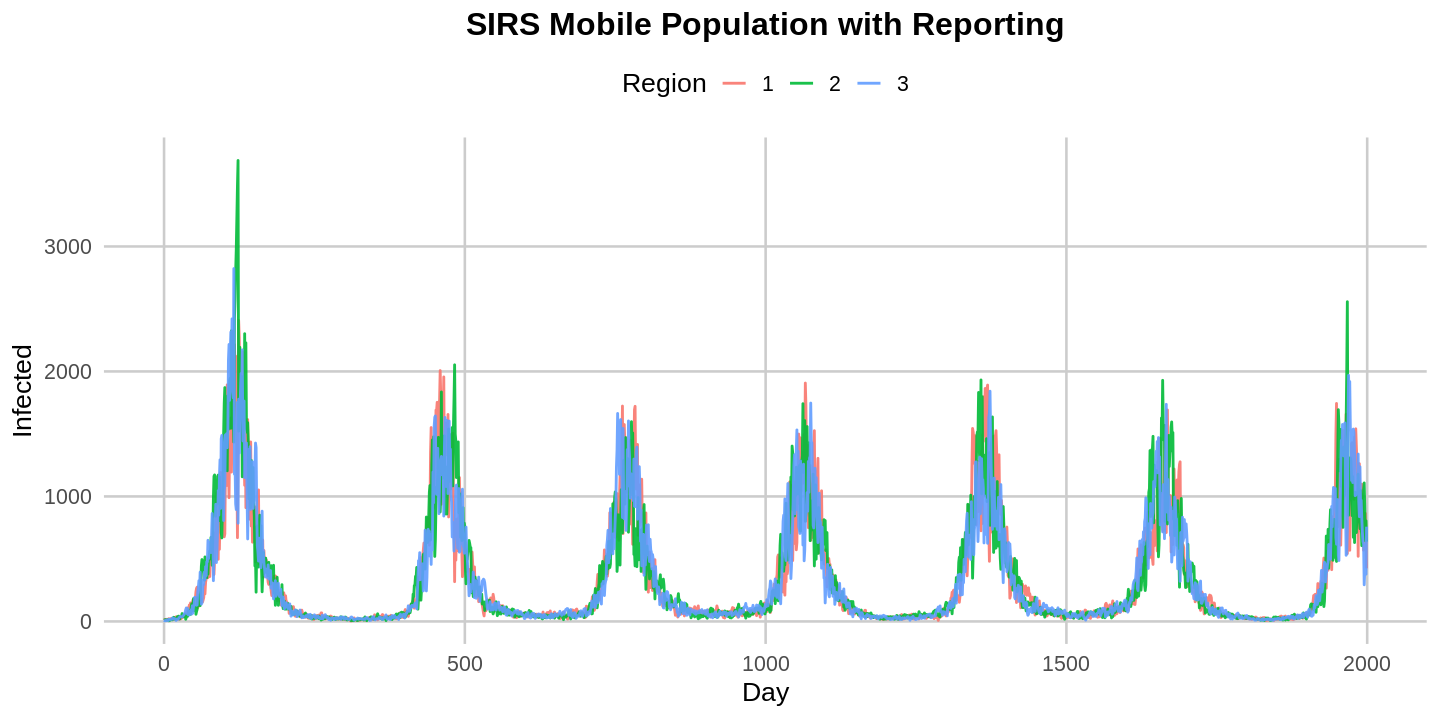

In [33]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(data, aes(x = Day, y = Infected, color = factor(Region))) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "SIRS Mobile Population with Reporting",
    x     = "Day",
    y     = "Infected",
    color = "Region"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    panel.grid.major  = element_line(color = "grey80"),
    panel.grid.minor  = element_blank(),
    plot.title        = element_text(face = "bold", hjust = 0.5),
    legend.position   = "top"
  )


In [34]:
burn_in <- 250

# 1. Cut (filter) data to post-burn-in only
data_processed <- data %>% filter(Day > burn_in)

# 2. Process outbreak periods on the filtered data
outbreak_periods <- data_processed %>%
  arrange(Day) %>%
  mutate(
    start_flag = (True.Outbreak == 1) & (lag(True.Outbreak, default = 0) == 0),
    end_flag   = (True.Outbreak == 0) & (lag(True.Outbreak, default = 1) == 1)
  ) %>%
  mutate(group = cumsum(start_flag)) %>%
  filter(True.Outbreak == 1) %>%
  group_by(group) %>%
  summarise(
    start = min(Day),
    end   = max(Day)
  )

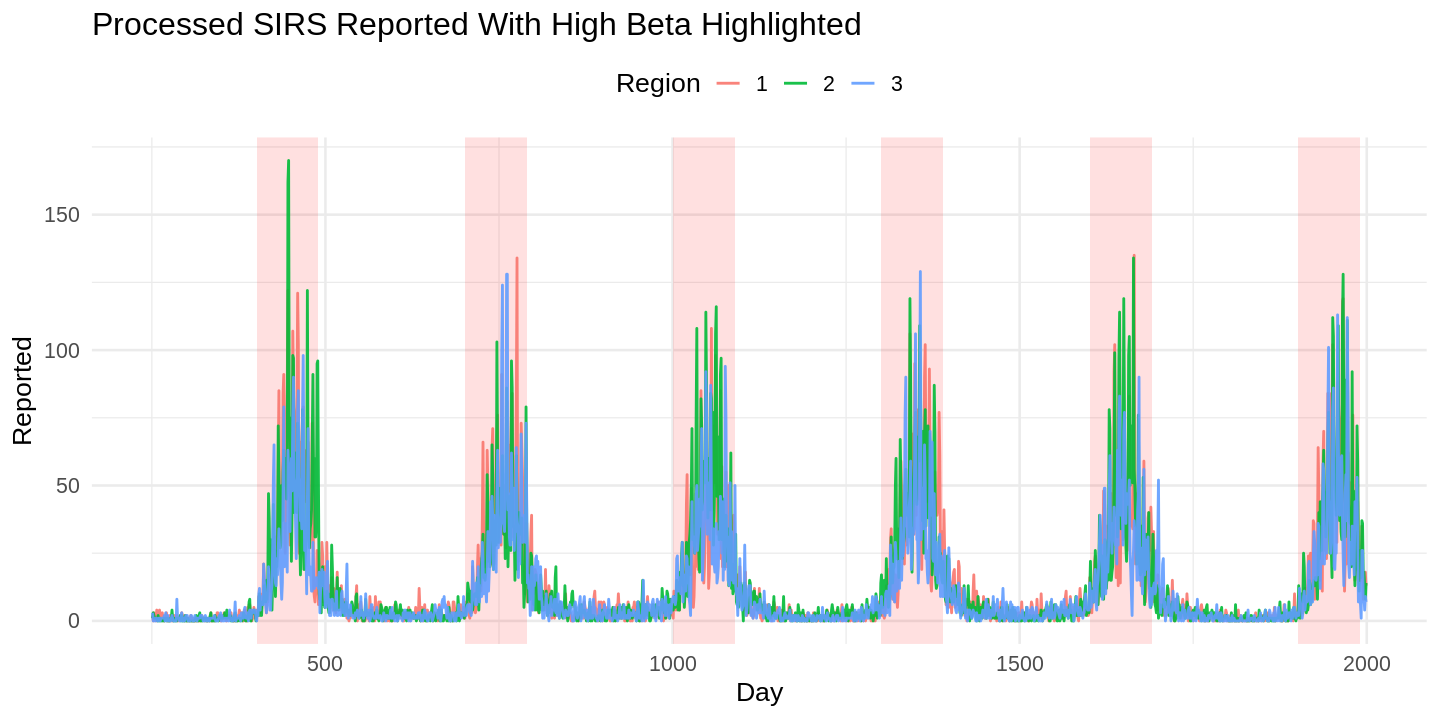

In [40]:
ggplot(data_processed, aes(x = Day, y = Reported.Cases, color = factor(Region))) +
  geom_rect(
    data = outbreak_periods,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12, inherit.aes = FALSE
  ) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "Processed SIRS Reported With High Beta Highlighted",
    x = "Day",
    y = "Reported",
    color = "Region"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "top"
  )


## Detection

In [80]:
region_id <- 1  # Change as needed
df <- data_processed %>% filter(Region == region_id) %>% arrange(Day)
cases <- df$Reported.Cases
true_label <- df$True.Outbreak
days <- df$Day
n <- nrow(df)

In [83]:
sts_obj <- sts(observed = df$Reported.Cases, freq = 1)

farr <- farringtonFlexible(
  sts_obj,
  control = list(
    b = 4,
    w = 7,
    noPeriods = 1,      # <-- Only 1 period for daily data!
    pastWeeksNotIncluded = 0,
    trend = FALSE
  )
)

farr_signal <- as.numeric(alarms(farr) > 0)

In [84]:
sts_cases <- sts(observed = df$Reported.Cases, freq = 1)
ears <- earsC(sts_cases, control = list(method = "C1", baseline = 7))
ears_signal <- as.numeric(alarms(ears) > 0)

In [85]:
arima_fit <- auto.arima(df$Reported.Cases)
pred <- forecast(arima_fit, h = n - burn_in)
pred_upper <- c(rep(NA, burn_in), pred$upper[,2])
arima_signal <- as.numeric(cases > pred_upper)
arima_signal[is.na(arima_signal)] <- 0  # set NA to 0 (no alarm in burn-in)

In [86]:
metrics <- function(true, detected) {
  TP <- sum(true == 1 & detected == 1)
  FP <- sum(true == 0 & detected == 1)
  TN <- sum(true == 0 & detected == 0)
  FN <- sum(true == 1 & detected == 0)
  Sensitivity <- ifelse((TP+FN)==0, NA, TP/(TP+FN))
  Specificity <- ifelse((TN+FP)==0, NA, TN/(TN+FP))
  Precision   <- ifelse((TP+FP)==0, NA, TP/(TP+FP))
  list(Sensitivity=Sensitivity, Specificity=Specificity, Precision=Precision)
}

In [87]:
# Timeliness: mean delay from true outbreak start to first detection, NA if never detected
timeliness <- function(true, detected) {
  # Find all start days of outbreak periods
  start_days <- which(diff(c(0, true)) == 1)
  delays <- c()
  for (start in start_days) {
    # Look for first detection at or after start
    alarm <- which(detected[(start):length(detected)] == 1)
    if (length(alarm) > 0) {
      delays <- c(delays, alarm[1] - 1)  # -1 because the first day is zero delay
    }
  }
  if (length(delays) == 0) return(NA)
  mean(delays)
}


In [88]:
length(true_label)
length(farr_signal)
length(ears_signal)
length(arima_signal)

[1] 1749

[1] 1738

[1] 1742

[1] 1749

In [89]:
# Find minimum length
min_len <- min(length(true_label), length(farr_signal), length(ears_signal), length(arima_signal))

# Trim all vectors to the last min_len values
true_label_cut   <- tail(true_label,   min_len)
farr_signal_cut  <- tail(farr_signal,  min_len)
ears_signal_cut  <- tail(ears_signal,  min_len)
arima_signal_cut <- tail(arima_signal, min_len)

In [90]:
# 3. Now use these in your results table
results <- tibble(
  Method = c("Farrington", "EARS", "ARIMA"),
  Sensitivity = c(
    metrics(true_label_cut, farr_signal_cut)$Sensitivity,
    metrics(true_label_cut, ears_signal_cut)$Sensitivity,
    metrics(true_label_cut, arima_signal_cut)$Sensitivity
  ),
  Specificity = c(
    metrics(true_label_cut, farr_signal_cut)$Specificity,
    metrics(true_label_cut, ears_signal_cut)$Specificity,
    metrics(true_label_cut, arima_signal_cut)$Specificity
  ),
  Precision = c(
    metrics(true_label_cut, farr_signal_cut)$Precision,
    metrics(true_label_cut, ears_signal_cut)$Precision,
    metrics(true_label_cut, arima_signal_cut)$Precision
  ),
  Timeliness = c(
    timeliness(true_label_cut, farr_signal_cut),
    timeliness(true_label_cut, ears_signal_cut),
    timeliness(true_label_cut, arima_signal_cut)
  )
)

print(results)

# A tibble: 3 × 5
  Method     Sensitivity Specificity Precision Timeliness
  <chr>            <dbl>       <dbl>     <dbl>      <dbl>
1 Farrington      0.0981       0.946     0.449       8   
2 EARS            0.0556       0.968     0.441       7.67
3 ARIMA           0.157        1         1          77.3 


In [93]:
df_cut <- tail(df, min_len)
df_cut$Farrington <- farr_signal_cut
df_cut$EARS       <- ears_signal_cut
df_cut$ARIMA      <- arima_signal_cut

df_long <- df_cut %>%
  pivot_longer(cols = c("Farrington", "EARS", "ARIMA"), names_to = "Method", values_to = "Detected")

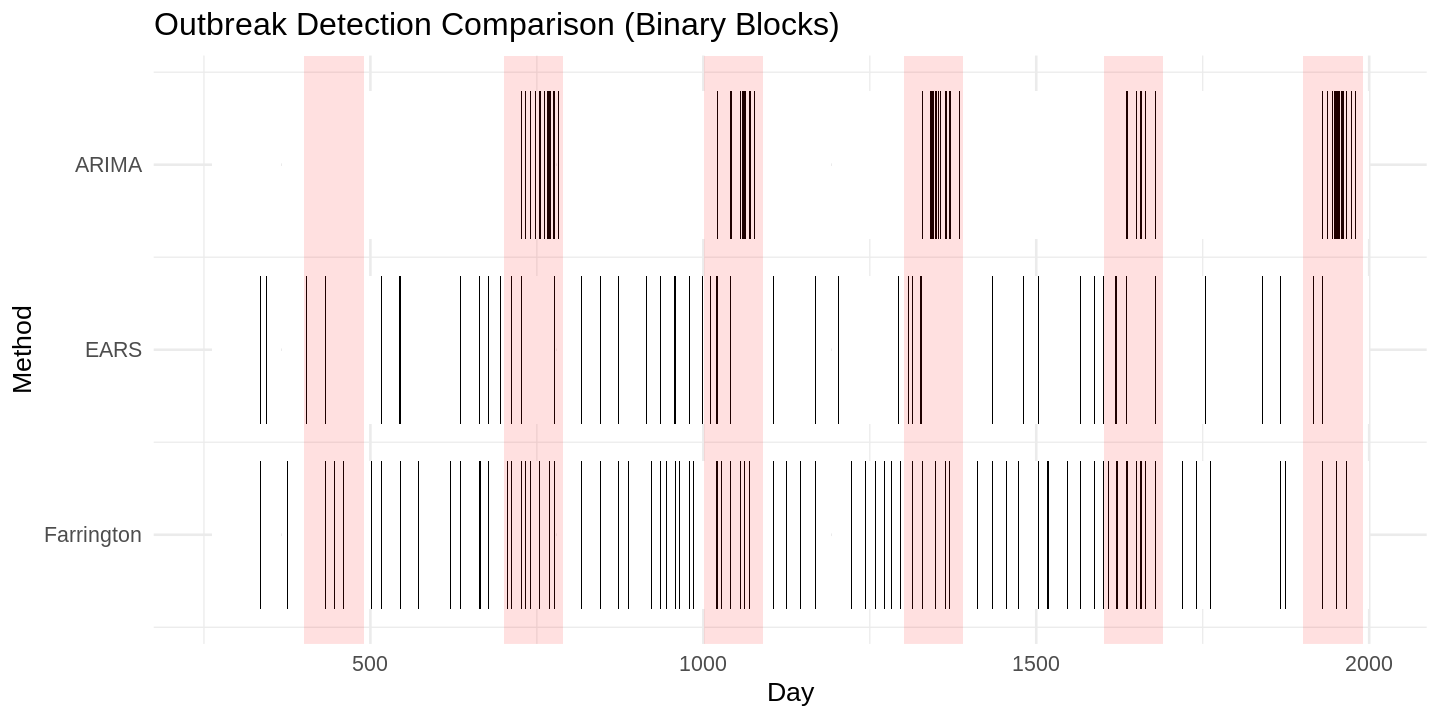

In [94]:
# 1. Prepare for blocks (offset for each method so they don't overlap)
method_levels <- c("Farrington", "EARS", "ARIMA")
df_long$Method <- factor(df_long$Method, levels = method_levels)

# Map each method to a vertical position
y_map <- setNames(seq_along(method_levels), method_levels)
df_long$BlockY <- y_map[as.character(df_long$Method)]

# 2. Plot the blocks
ggplot(df_long, aes(x = Day, y = BlockY, fill = as.factor(Detected))) +
  geom_tile(height = 0.8, width = 1, show.legend = FALSE) +
  # Outbreak periods (if you want shaded outbreaks in the background)
  geom_rect(
    data = outbreak_periods,
    inherit.aes = FALSE,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12
  ) +
  # Label y-axis with method names
  scale_y_continuous(
    breaks = y_map,
    labels = names(y_map),
    expand = c(0.05, 0.05)
  ) +
  scale_fill_manual(values = c("0" = "white", "1" = "black")) +
  labs(
    title = "Outbreak Detection Comparison (Binary Blocks)",
    y = "Method", x = "Day"
  ) +
  theme_minimal(base_size = 16)